<a href="https://colab.research.google.com/github/jhlee508/Colab/blob/master/Naver_Corporation_Stock_Prices_Forecasting/naver_stock_price_forecasting_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **RNN(Recurrent Neural Networks)/LSTM(Long Short Term Memory) 순환신경망을 사용하여 Naver Corporation(네이버)의 주식 가격을 예측하는 모델을 만들어본다.**


# **Library import**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

# **Load Dataset**

In [2]:
from google.colab import files
files.upload()

Saving naver.csv to naver.csv


{'naver.csv': b'Date,Open,High,Low,Close,Adj Close,Volume\n2016-04-21,132000.000000,133400.000000,131200.000000,133400.000000,132167.656250,412070\n2016-04-22,132000.000000,133000.000000,131400.000000,132600.000000,131375.031250,194870\n2016-04-25,132400.000000,133000.000000,131000.000000,132400.000000,131176.875000,355620\n2016-04-26,132600.000000,134400.000000,129800.000000,130800.000000,129591.664063,789600\n2016-04-27,129600.000000,133000.000000,128000.000000,133000.000000,131771.343750,403340\n2016-04-28,138200.000000,138200.000000,129200.000000,131800.000000,130582.414063,1141055\n2016-04-29,133600.000000,136200.000000,133200.000000,135400.000000,134149.187500,908665\n2016-05-02,135800.000000,136000.000000,133400.000000,135600.000000,134347.312500,288895\n2016-05-03,136400.000000,136400.000000,135000.000000,135200.000000,133951.015625,343900\n2016-05-04,135800.000000,136600.000000,134000.000000,136000.000000,134743.625000,697250\n2016-05-09,139800.000000,141000.000000,137400.0000

In [5]:
data = pd.read_csv('naver.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-21,132000.0,133400.0,131200.0,133400.0,132167.656250,412070.0
1,2016-04-22,132000.0,133000.0,131400.0,132600.0,131375.031250,194870.0
2,2016-04-25,132400.0,133000.0,131000.0,132400.0,131176.875000,355620.0
3,2016-04-26,132600.0,134400.0,129800.0,130800.0,129591.664063,789600.0
4,2016-04-27,129600.0,133000.0,128000.0,133000.0,131771.343750,403340.0
...,...,...,...,...,...,...,...
1222,2021-04-15,391500.0,398500.0,386500.0,391000.0,391000.000000,889538.0
1223,2021-04-16,394500.0,395000.0,391000.0,391500.0,391500.000000,423962.0
1224,2021-04-19,391500.0,393500.0,388500.0,390000.0,390000.000000,449064.0
1225,2021-04-20,389000.0,391500.0,387500.0,391000.0,391000.000000,417892.0


- Open(시가): 주식에서 처음 거래된 가격(우리나라 오전 9시)
- Close(종가): 당일 맨 마지막 거래가 체결된 가격(우리나라 오후 3시)
- High/Low: 최고거래가/최저거래가
- Adj Close: 수정 종가라는 뜻으로 분할, 배당, 배분, 신주 발생이 된 경우를 고려해 주식 가격을 조정(adjustment)해둔 가격
- Volume: 주식거래량



# **Data preprocessing**

In [6]:
# 데이터 개수 파악
data.count()

Date         1227
Open         1222
High         1222
Low          1222
Close        1222
Adj Close    1222
Volume       1222
dtype: int64

In [7]:
# 결측치 개수 파악
data.isnull().sum()

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [8]:
# 결측치가 있는 행 제거
data = data.dropna()
data.count()

Date         1222
Open         1222
High         1222
Low          1222
Close        1222
Adj Close    1222
Volume       1222
dtype: int64

In [14]:
# 고가와 저가의 중간 가격 구하기
high_prices = data['High']
low_prices = data['Low']
mid_prices = (high_prices + low_prices) / 2

mid_prices.shape

(1222,)

# **Visualize time series data**

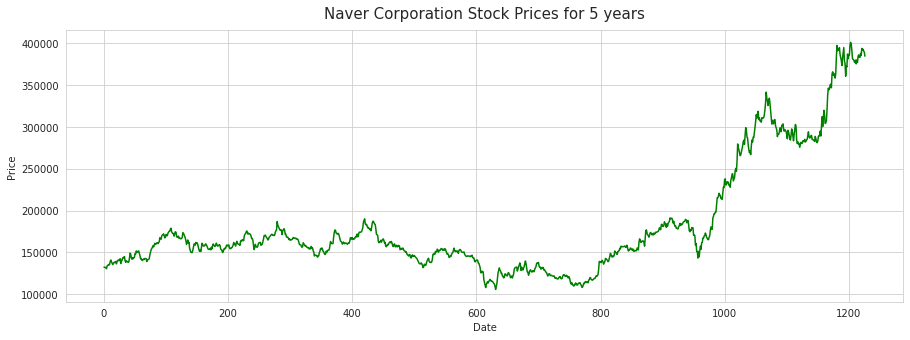

In [15]:
# 그래프로 시각화 해보기
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
plt.plot(mid_prices, c = 'g')
plt.title("Naver Corporation Stock Prices for 5 years", size = 15, y = 1.02)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# **Create Sequence**
- Sequence Size = 50 + 1
- 첫 번째 sequence는 50일 치의 값으로 그 다음 날의 값을 예측한다. 
- 그리고 두 번째 window는 하루 씩 밀려서 첫 날의 그 다음 날부터 50일치의 값으로 그 다음 날의 값을 예측한다. 
- 이러한 과정을 반복한다.

In [16]:
n_steps = 50 # time step = 50 
sequence_length = n_steps + 1 # 총 window size

# 리스트 생성
series = [] 

# result 리스트는 index 별로 51일치의 data가 들어감. 총 길이는 전체에서 51일을 뺀 값
for index in range(len(mid_prices) - sequence_length):
    series.append(mid_prices[index:index + sequence_length])

In [17]:
len(series[0])

51

In [18]:
len(series)

1171

# **Normalize Data**

In [19]:
normalized_data = []
window_mean = []
window_std = []

# Z-Score Normalization
for window in series:
    normalized_window = [((p - np.mean(window))/np.std(window)) for p in window]
    normalized_data.append(normalized_window) 
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

# 여기서 result는 Z-Score Normalization 되어진 dataset
series = np.array(normalized_data)

# **Train Valid Test split**

In [20]:
# 전체를 7:2:1 으로 분할
row1 = int(round(series.shape[0] * 0.7))
row2 = int(round(series.shape[0] * 0.2))
print(row1, row2, len(series) - (row1+row2))

820 234 117


In [21]:
# train, valid, test 분할
X_train, y_train = series[:row1, :n_steps], series[:row1, -1]
X_valid, y_valid = series[row1:row1+row2, :n_steps], series[row1:row1+row2, -1]
X_test, y_test = series[row1+row2:, :n_steps], series[row1+row2:, -1]

In [22]:
X_train.shape, y_train.shape

((820, 50), (820,))

In [23]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(y_train.shape[0], 1)
y_valid = y_valid.reshape(y_valid.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train.shape, y_train.shape

((820, 50, 1), (820, 1))

- 학습데이터: 배치 사이즈 = 820, 타입 스텝 수 = 50, 단변량 값

# **Build a Model**

In [53]:
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 50, 128)           66560     
_________________________________________________________________
lstm_27 (LSTM)               (None, 50, 128)           131584    
_________________________________________________________________
lstm_28 (LSTM)               (None, 50, 128)           131584    
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


# **Training**

In [54]:
model.fit(X_train, y_train, 
          epochs=30,
          validation_data=(X_valid, y_valid))

Epoch 1/30
26/26 [==============================] - 15s 331ms/step - loss: 1.1810 - val_loss: 0.5229
Epoch 2/30
26/26 [==============================] - 6s 248ms/step - loss: 0.5109 - val_loss: 0.3144
Epoch 3/30
26/26 [==============================] - 6s 251ms/step - loss: 0.4385 - val_loss: 0.3889
Epoch 4/30
26/26 [==============================] - 6s 248ms/step - loss: 0.3706 - val_loss: 0.2578
Epoch 5/30
26/26 [==============================] - 6s 246ms/step - loss: 0.4006 - val_loss: 0.2570
Epoch 6/30
26/26 [==============================] - 6s 248ms/step - loss: 0.3126 - val_loss: 0.4748
Epoch 7/30
26/26 [==============================] - 6s 249ms/step - loss: 0.3542 - val_loss: 0.2133
Epoch 8/30
26/26 [==============================] - 6s 250ms/step - loss: 0.2581 - val_loss: 0.3314
Epoch 9/30
26/26 [==============================] - 6s 249ms/step - loss: 0.3573 - val_loss: 0.3657
Epoch 10/30
26/26 [==============================] - 6s 249ms/step - loss: 0.3511 - val_loss: 0.179

# **Prediction**

In [55]:
# 테스트 데이터 평가
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 72ms/step - loss: 0.1601


0.16012273728847504

In [56]:
# 예측값 구하기
predicted = model.predict(X_test)

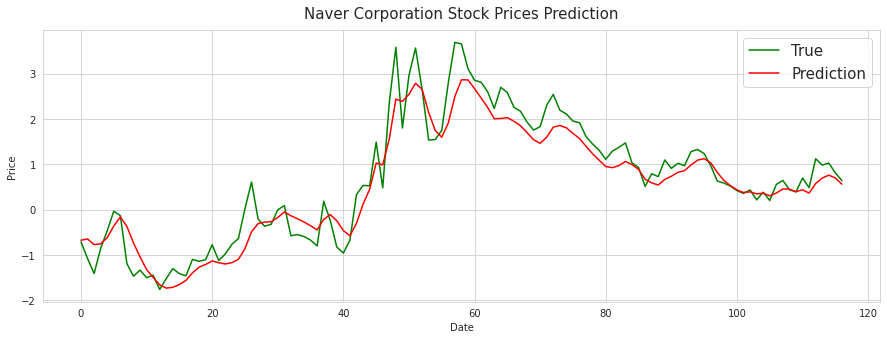

In [57]:
# 시각화
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True', c = 'g')
plt.plot(predicted, label='Prediction', c = 'r')
plt.title("Naver Corporation Stock Prices Prediction", size = 15, y = 1.02)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize = 15)
plt.show()